In [8]:
import os
import sys
from copy import deepcopy

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from gymnasium.wrappers import RescaleAction, NormalizeObservation, NormalizeReward
from torch import nn
from torch.distributions import Normal
from torch.optim import Adam

sys.path.append(os.path.abspath(".."))

from rlib.algorithms.ddpg import ddpg
from rlib.algorithms.sac import sac
from rlib.algorithms.td3 import td3
from rlib.common.evaluation import get_trajectory, validation
from rlib.common.logger import TensorBoardLogger
from rlib.common.policies import DeterministicMlpPolicy, MlpQCritic, StochasticMlpPolicy

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
env = gym.make("Pendulum-v1", render_mode="rgb_array")

min_action, max_action = -1, 1
env = RescaleAction(env, min_action, max_action)
env = NormalizeObservation(env)

discrete = False

In [10]:
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print(obs_dim, action_dim)

3 1


### DDPG

In [8]:
actor = DeterministicMlpPolicy(obs_dim, action_dim)
critic = MlpQCritic(obs_dim, action_dim)

actor_optimizer = Adam(actor.parameters(), lr=1e-4)
critic_optimizer = Adam(critic.parameters(), lr=1e-3)

In [9]:
ddpg(env, actor, critic, actor_optimizer, critic_optimizer, total_timesteps=100_000)

In [10]:
validation(env, actor, deterministic=True)

-163.82522944874415

### TD3

In [28]:
actor = DeterministicMlpPolicy(obs_dim, action_dim)
critic_1 = MlpQCritic(obs_dim, action_dim)
critic_2 = MlpQCritic(obs_dim, action_dim)

actor_optimizer = Adam(actor.parameters(), lr=1e-4)
critic_1_optimizer = Adam(critic_1.parameters(), lr=1e-3)
critic_2_optimizer = Adam(critic_2.parameters(), lr=1e-3)

In [ ]:
td3(
    env,
    actor,
    critic_1,
    critic_2,
    actor_optimizer,
    critic_1_optimizer,
    critic_2_optimizer,
    total_timesteps=100_000,
)

In [ ]:
validation(env, actor, validation_n=100, deterministic=True)

-1427.9277668169286

### SAC

In [11]:
actor = StochasticMlpPolicy(obs_dim, action_dim)
critic_1 = MlpQCritic(obs_dim, action_dim)
critic_2 = MlpQCritic(obs_dim, action_dim)

actor_optimizer = Adam(actor.parameters(), lr=1e-4)
critic_1_optimizer = Adam(critic_1.parameters(), lr=1e-3)
critic_2_optimizer = Adam(critic_2.parameters(), lr=1e-3)

In [15]:
sac(
    env,
    actor,
    critic_1,
    critic_2,
    actor_optimizer,
    critic_1_optimizer,
    critic_2_optimizer,
    total_timesteps=5_000,
)

In [22]:
validation(env, actor, deterministic=True)

-756.9275584807227

MovieWriter imagemagick unavailable; using Pillow instead.


saving...
-1329.6332340560125


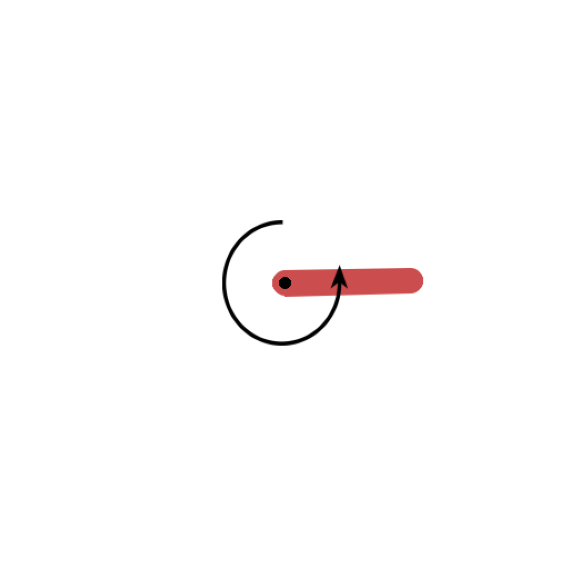

In [23]:
traj = get_trajectory(env, actor, visualize=True)
print(sum(traj["rewards"]))

### db

In [42]:
rb = ReplayBuffer(obs_dim, action_dim)

In [43]:
for _ in range(20):
    rb.collect_transition(env, actor)

In [44]:
data = rb.get_batch(10)

In [47]:
actor_target = deepcopy(actor)
critic_target = deepcopy(critic)
gamma = 0.99

In [ ]:
critic_1_target = deepcopy(critic_1)
critic_2_target = deepcopy(critic_2)

policy_std = 0.2
policy_clip = 0.5

In [54]:
loss = {}

observations = data["observations"]
next_observations = data["next_observations"]
actions = data["actions"]
rewards = data["rewards"]
terminated = data["terminated"]

actor_outputs = actor(observations)
loss["actor"] = -critic(observations, actor_outputs).mean()

with torch.no_grad():
    actions_target = actor_target(next_observations)
    targets = rewards + gamma * (~terminated) * critic_target(
        next_observations, actions_target
    )

q_values = critic(observations, actions)
loss["critic"] = ((q_values - targets) ** 2).mean()

print(actor_outputs.shape, critic(observations, actor_outputs).shape)
print(actions_target.shape, targets.shape)
print(loss["actor"].shape, loss["critic"].shape)

torch.Size([10, 1]) torch.Size([10, 1])
torch.Size([10, 1]) torch.Size([10, 1])
torch.Size([]) torch.Size([])


In [55]:
loss = {}

observations = data["observations"]

actor_outputs = actor(observations)
loss["actor"] = -critic_1(observations, actor_outputs).mean()

actions = data["actions"]
next_observations = data["next_observations"]
rewards = data["rewards"].reshape(actor_outputs.shape)
terminated = data["terminated"].reshape(actor_outputs.shape)

with torch.no_grad():
    actions_target = actor_target(next_observations)

    loc = torch.zeros_like(actions_target)
    scale = policy_std * torch.ones_like(actions_target)
    dist = Normal(loc, scale)
    epsilon = torch.clamp(dist.sample(), -policy_clip, policy_clip)

    actions_target = actions_target + epsilon

    target_q_values = torch.min(
        critic_1_target(next_observations, actions_target),
        critic_2_target(next_observations, actions_target),
    )

    targets = rewards + gamma * (~terminated) * target_q_values

q_values_1 = critic_1(observations, actions)
q_values_2 = critic_2(observations, actions)

loss["critic_1"] = ((q_values_1 - targets) ** 2).mean()
loss["critic_2"] = ((q_values_2 - targets) ** 2).mean()

print(actor_outputs.shape, critic_1(observations, actor_outputs).shape)
print(actions_target.shape, target_q_values.shape, q_values_1.shape, targets.shape)

print(loss["actor"])
print(loss["critic_1"])
print(loss["critic_2"])

NameError: name 'critic_1' is not defined

In [42]:
critic_1.forward(observations, actions)

tensor([[-523.3286],
        [-526.9666],
        [-525.1102],
        [-525.8734],
        [-526.4110],
        [-523.8635],
        [-524.0366],
        [-524.4642],
        [-524.8064],
        [-525.6659]], grad_fn=<AddmmBackward0>)